In [ ]:
import numpy as np
import pandas as pd
import warnings
import plotly.express as px
import seaborn as sns
warnings.filterwarnings("ignore")
pd.set_option("display.float_format","{:.5f}".format)

In [69]:
df=pd.read_csv("e_commerce.csv")
#https://www.kaggle.com/datasets/prachi13/customer-analytics

In [70]:
df.columns,df.shape

(Index(['ID', 'Warehouse_block', 'Mode_of_Shipment', 'Customer_care_calls',
        'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases',
        'Product_importance', 'Gender', 'Discount_offered', 'Weight_in_gms',
        'Reached.on.Time_Y.N'],
       dtype='object'),
 (10999, 12))

In [71]:
df.isnull().sum()

ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0
Prior_purchases        0
Product_importance     0
Gender                 0
Discount_offered       0
Weight_in_gms          0
Reached.on.Time_Y.N    0
dtype: int64

There are no missing values

# Exploratory data analysis

In [72]:
df["Reached.on.Time_Y.N"].mean()

0.5966906082371125

The target variable is fairly balanced

<Axes: xlabel='Warehouse_block', ylabel='count'>

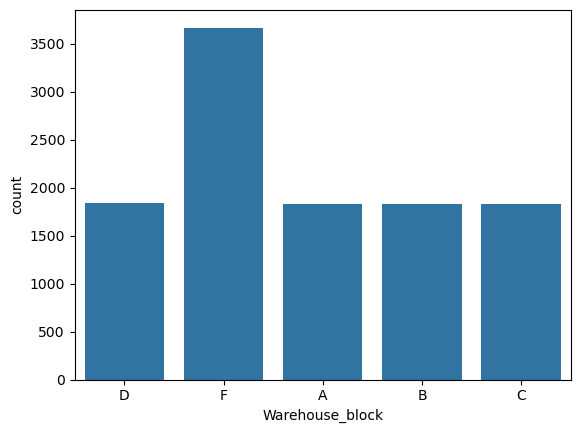

In [73]:
sns.countplot(df,x="Warehouse_block")


Most products that were delevered on time came from warehouse block F. This is due to the fact that overall most items came from warehouse block F

In [74]:
df["Warehouse_block"].value_counts()

Warehouse_block
F    3666
D    1834
A    1833
B    1833
C    1833
Name: count, dtype: int64

In [75]:
df.groupby("Warehouse_block")["Reached.on.Time_Y.N"].mean()

Warehouse_block
A   0.58647
B   0.60229
C   0.59684
D   0.59760
F   0.59847
Name: Reached.on.Time_Y.N, dtype: float64

In terms of which warehouse block the products came in time, the is no significant difference

<Axes: xlabel='Mode_of_Shipment', ylabel='Reached.on.Time_Y.N'>

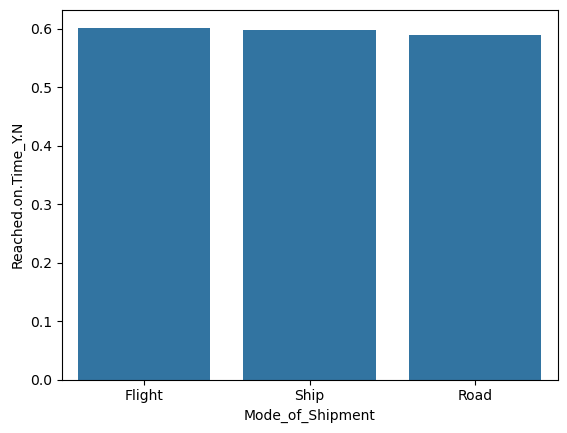

In [76]:
sns.barplot(df,y="Reached.on.Time_Y.N",x="Mode_of_Shipment",ci=None)

In [77]:
df.groupby("Mode_of_Shipment")["Reached.on.Time_Y.N"].mean()

Mode_of_Shipment
Flight   0.60158
Road     0.58807
Ship     0.59756
Name: Reached.on.Time_Y.N, dtype: float64

In [78]:
# the mode of shipment seems to have no effect on whether the product arrived on time

In [79]:
df.groupby("Reached.on.Time_Y.N")["Weight_in_gms"].mean()

Reached.on.Time_Y.N
0   4168.66839
1   3272.64010
Name: Weight_in_gms, dtype: float64

<Axes: xlabel='Cost_of_the_Product'>

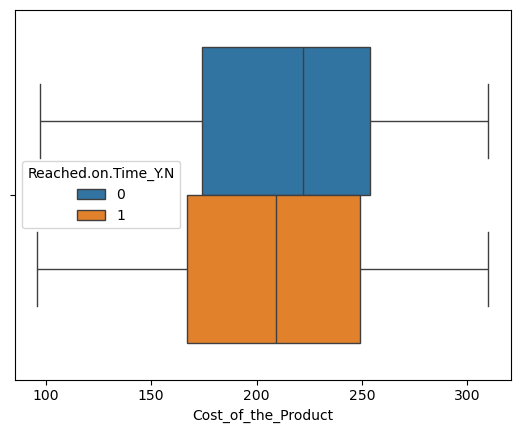

In [80]:
#Products that arrived on time tended to be lighter 
sns.boxplot(df,x="Cost_of_the_Product",hue="Reached.on.Time_Y.N")

Most of the products that arrived on time had a lower cost than those that arrived late

# Supervised learning


first we will scale our independent variables 

In [112]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,recall_score
from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [82]:
#--- Preprocessing---
X=df.drop("Reached.on.Time_Y.N",axis=1)
y=df["Reached.on.Time_Y.N"]

In [91]:
categorical_cols=X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols=X.select_dtypes(include=["int64","float64"]).columns.tolist()

In [92]:
numeric_transformer=StandardScaler()
categorical_transformer=OneHotEncoder()
preprocessor=ColumnTransformer(
    transformers=[
        ("num",numeric_transformer,numeric_cols),
        ("cat",categorical_transformer,categorical_cols)
    ]
)

In [93]:
#Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

In [101]:
# --- Model 1: SVC ---s
svc_pipeline=Pipeline(steps=[
    ("preprocessor",preprocessor),
    ("SVC",SVC())
])
param_grid={ 
    "SVC__C":[0.1,1,10],
    "SVC__kernel":["linear","rbf"],
    "SVC__gamma":["scale","auto"]
}


In [107]:
grid_search_svc = GridSearchCV(
    estimator=svc_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2)
grid_search_svc.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ID',
                                                                          'Customer_care_calls',
                                                                          'Customer_rating',
                                                                          'Cost_of_the_Product',
                                                                          'Prior_purchases',
                                                                          'Discount_offered',
                                                                          'Weight_in_gms']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Warehouse_block',
                                                                          'Mode_of_Shipment',
                                                                          'Product_importance',
                                                                          'Gender'])])),
                                       ('SVC', SVC())]),
             n_jobs=-1,
             param_grid={'SVC__C': [0.1, 1, 10],
                         'SVC__gamma': ['scale', 'auto'],
                         'SVC__kernel': ['linear', 'rbf']},
             scoring='accuracy', verbose=2)

In [104]:
best_model= grid_search.best_estimator_
y_pred_SVC=best_model.predict(X_test)

In [109]:
#--- Logistic Regression ---
logistic_pipeline=Pipeline(steps=
[
    ("preprocessor",preprocessor),
    ("LogisticRegression",LogisticRegression(max_iter=1000))
])
param_grid={
    "LogisticRegression__C":[0.1,1,10],
    "LogisticRegression__penalty":["l2"],
    "LogisticRegression__solver":["lbfgs","liblinear"]  
}
grid_search_logistic=GridSearchCV(
    estimator=logistic_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy"
)
best_model=grid_search_logistic.fit(X_train,y_train)
y_pred_logistic=best_model.predict(X_test)

In [111]:
# ---KNN Classifier ---
knn_pipeline=Pipeline(
    [
        ("preprocessor",preprocessor),
        ("KNclassifier",KNeighborsClassifier())
    ]
)
param_grid_knn={
    "KNclassifier__n_neighbors":[3,5,7],
    "KNclassifier__weights":["uniform","distance"],
    "KNclassifier__metric":["euclidean","manhattan"]
}
grid_search_knn=GridSearchCV(
    estimator=knn_pipeline,
    param_grid=param_grid_knn,
    cv=5,
    scoring="accuracy")
best_model=grid_search_knn.fit(X_train,y_train)
y_pred_knn=best_model.predict(X_test)

In [115]:
# --- Random Forest Classifier ---
rf_pipeline=Pipeline(steps=[
    ("preprocessor",preprocessor),
    ("rfc",RandomForestClassifier())
])
param_grid_rf={
    "rfc__n_estimators":[10,20,50,],
    "rfc__max_depth":[None,10,20],
    "rfc__min_samples_split":[2,5],
    "rfc__min_samples_leaf":[1,2]
}
grid_search_rf=GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring="accuracy",
)
best_model=grid_search_rf.fit(X_train,y_train)
y_pred_rf=best_model.predict(X_test)

In [116]:
def model_evaluation(y_test,y_pred):
    print("classification report:\n", classification_report(y_test, y_pred))
    print("confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("accuracy score:", accuracy_score(y_test, y_pred))

In [117]:
model_evaluation(y_test,y_pred_SVC)

classification report:
               precision    recall  f1-score   support

           0       0.56      0.95      0.71       867
           1       0.94      0.51      0.66      1333

    accuracy                           0.69      2200
   macro avg       0.75      0.73      0.69      2200
weighted avg       0.79      0.69      0.68      2200

confusion matrix:
 [[826  41]
 [649 684]]
accuracy score: 0.6863636363636364


In [118]:
model_evaluation(y_test,y_pred_logistic)

classification report:
               precision    recall  f1-score   support

           0       0.56      0.62      0.59       867
           1       0.73      0.69      0.71      1333

    accuracy                           0.66      2200
   macro avg       0.65      0.65      0.65      2200
weighted avg       0.67      0.66      0.66      2200

confusion matrix:
 [[534 333]
 [417 916]]
accuracy score: 0.6590909090909091


In [119]:
model_evaluation(y_test,y_pred_knn)

classification report:
               precision    recall  f1-score   support

           0       0.55      0.62      0.59       867
           1       0.73      0.67      0.70      1333

    accuracy                           0.65      2200
   macro avg       0.64      0.65      0.64      2200
weighted avg       0.66      0.65      0.66      2200

confusion matrix:
 [[540 327]
 [436 897]]
accuracy score: 0.6531818181818182


In [120]:
model_evaluation(y_test,y_pred_rf)

classification report:
               precision    recall  f1-score   support

           0       0.56      0.90      0.69       867
           1       0.89      0.54      0.68      1333

    accuracy                           0.68      2200
   macro avg       0.73      0.72      0.68      2200
weighted avg       0.76      0.68      0.68      2200

confusion matrix:
 [[779  88]
 [607 726]]
accuracy score: 0.6840909090909091


The best accuracy (68%) is reached for the random forest and svm classifiers